In [1]:
import matplotlib.pyplot as plt
plt.xlabel
plt.ylabel

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)>

In [2]:
from WindPy import w
import pandas as pd
import datetime as dt
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import zlib
w.start()
etfList = ["510300.SH", "510050.SH", "159919.SZ"]

KeyboardInterrupt: 

In [3]:
from WindPy import w
import pandas as pd
import datetime as dt
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import zlib
w.start()
etfList = ["510300.SH", "510050.SH", "159919.SZ"]

In [4]:

# # %%
# def windDownloadIOPV(windObj, etfName):
#     res = windObj.wst(etfName, "iopv", "2020-01-02 09:00:00", "2020-05-01 15:00:00", "")
#     timeseries = res.Times
#     iopv = res.Data[0]
#     iopvDF = pd.DataFrame({'timeStamp':timeseries, 'iopv':iopv})
#     iopvDF.to_csv(etfName+".csv", index=False)
#     return iopvDF
# #%%
# iopvDFList = {}
# for etfname in etfList:
#     iopvDFList[etfname] = windDownloadIOPV(w,etfname)
# # %%
# iopvChgList = {}
# for etfname in iopvDFList:
#     iopvDF = iopvDFList[etfname]
#     iopvDF['time'] = iopvDF['timeStamp'].dt.time
#     iopvDF['date'] = iopvDF['timeStamp'].dt.date
#     iopvDF['iopv_lag'] = iopvDF.groupby(['date'])['iopv'].shift(1)
#     iopvChg = iopvDF[iopvDF['iopv']!=iopvDF['iopv_lag']]
#     iopvChg.to_csv(etfname+"_chg.csv", index=False)    
#     iopvChgList[etfname] = iopvChg

In [5]:
os.chdir("C:/Users/Yitong/AppData/Local/auto-option-mm/PythonProject/Wind/0417-0428")
iopvChgList = {}
for etfname in etfList:
    iopvChgList[etfname] = pd.read_csv(etfname+"_chg.csv")
    iopvChgList[etfname]['timeStamp'] = pd.to_datetime(iopvChgList[etfname]['timeStamp'])
    iopvChgList[etfname]['date'] = pd.to_datetime(iopvChgList[etfname]['date']).dt.date
    iopvChgList[etfname]['time'] = pd.to_datetime(iopvChgList[etfname]['time']).dt.time


In [6]:
os.chdir("C:/Users/Yitong/AppData/Local/auto-option-mm/SpotDetail")
expSpotList = {}
for filename in os.listdir():
    if(not filename.startswith("SpotDetail")):
        continue
    exp = filename[11:19]
    date = filename[20:28]
    if (exp in expSpotList):
        curDF = pd.read_csv(filename)
        curDF['Exp'] = exp
        curDF['Date'] = date
        expSpotList[exp] = pd.concat([expSpotList[exp],curDF], axis=0)        
        expSpotList[exp] = expSpotList[exp].reset_index(drop=True)   
    else:
        expSpotList[exp] = pd.read_csv(filename)
        expSpotList[exp]['Exp'] = exp
        expSpotList[exp]['Date'] = date



In [7]:
for exp in expSpotList:
   expSpotList[exp]['timestamp'] = pd.to_datetime(expSpotList[exp]['Date']+' '+expSpotList[exp]['time'], infer_datetime_format=True)
   expSpotList[exp]['date'] =  expSpotList[exp]['timestamp'].dt.date
   expSpotList[exp]['time'] =  expSpotList[exp]['timestamp'].dt.time
   expSpotList[exp].drop(columns = ['millisec','Date'], inplace=True)


In [8]:
def binarySearch_RowOps(target, arr, l, r):
    
    timeStamp = target['timeStamp']
    return arr[binarySearch(timeStamp, arr, l, r)]

def binarySearch(target, arr, l, r):
    #print("Left Index " + str(l) + "  Right Index " + str(r)+'\n')
    if r>l:
        mid = (l + r-1)//2
        #print("Target " + str(target) + " l " + str(l) + " r " + str(r) + " mid " + str(mid)+ " midT " +str(arr[mid]))
        if(arr[mid]==target):
            return mid
        elif(arr[mid]>target):
            if(arr[mid-1]<target):
                return mid
            else:
                return binarySearch(target, arr, l, mid-1)
        else:
            return binarySearch(target, arr, mid+1, r)
    elif r==l:
        return r
    else:
        return -1#%%

In [9]:
curExpDF = expSpotList['20200527']
iopv50 = iopvChgList["510050.SH"]

maxDate = curExpDF['date'].max()
minDate = curExpDF['date'].min()
iopv50 = iopv50[iopv50['date']<= maxDate]
iopv50 = iopv50[iopv50['date']>= minDate]
iopv50 = iopv50[iopv50['time']>= dt.time(9,30,0)]
iopv50['matchedTime'] = iopv50.apply(binarySearch_RowOps, args = (curExpDF['timestamp'].array, 0,len(curExpDF['timestamp'])-1),axis=1)


In [10]:
mergedDF = pd.merge(curExpDF,iopv50,'outer',left_on='timestamp', right_on='matchedTime')

In [11]:
mergedDF['iopvR'] = mergedDF['iopv'] / mergedDF['etf_preclose']
mergedDF['futureR'] = mergedDF['fut'] / mergedDF['fut_preclose']
mergedDF = mergedDF[mergedDF['time_x']>= dt.time(9,30,0)]


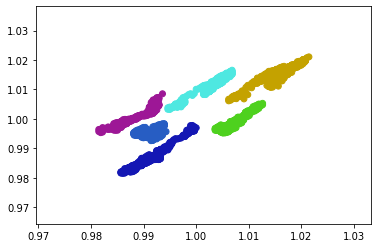

In [12]:
def date2color(dateinput):
    datestr = dt.datetime.strftime(dateinput, format="%Y%m%d")
    tmpnum = int(zlib.crc32(datestr.encode('utf-8')))
    r = (tmpnum%13) / 13
    g = (tmpnum%11) / 11
    b = (tmpnum%17) / 17

    color = [r,g,b]
    return color

fig, ax = plt.subplots()
ax.scatter(mergedDF['iopvR'], mergedDF['futureR'],c=mergedDF['date_x'].apply(lambda x: date2color(x)))
plt.show()

In [13]:
#this func regress futureR and iopvR and compare the slope/intercept
#result implies both slope/intercept would shift
def futureIopvOLS(data):
    X1 = data['futureR'].values
    X1= sm.add_constant(X1)
    y1 = data['iopvR'].values
    model = sm.OLS(y1,X1,missing='drop').fit()
    print("Date: "+dt.datetime.strftime(data['date_x'].iloc[0], format="%Y%m%d")+"Intercept: {:1f}  Slope: {:1f} R2 {:.2%}".format(model.params[0],model.params[1], model.rsquared))


mergedDF.groupby('date_x').apply(futureIopvOLS)

Date: 20200417Intercept: 0.023079  Slope: 0.977326 R2 85.80%
Date: 20200417Intercept: 0.023079  Slope: 0.977326 R2 85.80%
Date: 20200421Intercept: 0.117128  Slope: 0.885900 R2 95.18%
Date: 20200422Intercept: -0.038765  Slope: 1.026477 R2 90.47%
Date: 20200423Intercept: 0.248449  Slope: 0.759901 R2 88.50%
Date: 20200424Intercept: 0.364351  Slope: 0.629412 R2 16.77%
Date: 20200427Intercept: 0.121999  Slope: 0.871255 R2 92.67%


""


In [14]:
def fut_iopv_compare(data):
    X1 = data['fut'].values
    X1= sm.add_constant(X1)
    X2 = data['optionSpot'].values
    X2 = sm.add_constant(X2)

    y1 = data['iopv'].values
    model1 = sm.OLS(y1,X1,missing='drop').fit()
    model2= sm.OLS(y1,X2,missing='drop').fit()

    print("FutR2 {:.2%}, IopvR2 {:.2%}".format(model1.rsquared, model2.rsquared))

mergedDF.groupby('date_x').apply(fut_iopv_compare)



FutR2 85.80%, IopvR2 76.42%
FutR2 85.80%, IopvR2 76.42%
FutR2 95.18%, IopvR2 93.95%
FutR2 90.47%, IopvR2 87.98%
FutR2 88.50%, IopvR2 89.83%
FutR2 16.77%, IopvR2 19.11%
FutR2 92.67%, IopvR2 92.95%


""


In [15]:
def gen_iopvSpotTheory(olsWindow, mergedDF):
    ols_windowSize = olsWindow
    bo_windowSize = 120
    fut_r_array= []
    iopv_r_array = []
    boArray = []
    intercept = 0 
    slope = 0.98
    for row in mergedDF.itertuples():
        if(not np.isnan(row.iopvR)):
            fut_r_array.append(row.futureR)
            iopv_r_array.append(row.iopvR)
            if(len(fut_r_array)>ols_windowSize*0.5):
                print()
                X1 = sm.add_constant(fut_r_array)
                Y1 = iopv_r_array
                model = sm.OLS(Y1,X1, missing='drop').fit()
                intercept = model.params[0]
                slope = model.params[1]
                print("new slope{:1f}, new intercept{:1f}".format(slope,intercept))
            while(len(fut_r_array)>ols_windowSize):
                del fut_r_array[0]
            while(len(iopv_r_array)>ols_windowSize):
                del iopv_r_array[0]
        mergedDF.loc[row.Index, 'b0'] = intercept
        mergedDF.loc[row.Index, 'b1'] = slope
    mergedDF['iopvR'+str(ols_windowSize)] = mergedDF['b0'] + mergedDF['b1'] * mergedDF['futureR']
    mergedDF['iopv'+str(ols_windowSize)] = mergedDF['iopvR'+str(ols_windowSize)] * mergedDF['etf_preclose']
    mergedDF['rawBo' + str(ols_windowSize)] = mergedDF['optionSpot'] - mergedDF['iopv'+str(ols_windowSize)]
    mergedDF['bo'+str(ols_windowSize)] = mergedDF['rawBo' + str(ols_windowSize)].rolling(120).mean()
    mergedDF['spotTheo'+ str(ols_windowSize)] = mergedDF['bo'+str(ols_windowSize)] + mergedDF['iopv'+str(ols_windowSize)]


In [16]:
def gen_PredictionGraph(olsWindow, mergedDF,lag):
    ols_windowSize = olsWindow
    lag_tick = lag
    mergedDFshort = mergedDF[mergedDF['date_x']>dt.datetime(2020,4,17).date()]
    mergedDFshort['spotTheoR_l5'] = mergedDFshort['spotTheo'] / mergedDFshort['spotTheo'].shift(lag_tick)
    mergedDFshort['spotTheoR_iopv_l5'] = mergedDFshort['spotTheo'+ str(ols_windowSize)] / mergedDFshort['spotTheo'+ str(ols_windowSize)].shift(lag_tick)

    x1 = sm.add_constant(mergedDFshort['spotTheoR_l5'].values)
    x2 = sm.add_constant(mergedDFshort['spotTheoR_iopv_l5'].values)
    y1 = (mergedDFshort['optionSpot'] / mergedDFshort['optionSpot'].shift(lag_tick)).values
    model1 = sm.OLS(y1,x1,missing='drop').fit()
    model2 = sm.OLS(y1,x2,missing='drop').fit()
    return (model1.rsquared, model2.rsquared)


e0.648050, new intercept0.348494

new slope0.675367, new intercept0.320799

new slope0.679009, new intercept0.317111

new slope0.708295, new intercept0.287428

new slope0.746599, new intercept0.248590

new slope0.755828, new intercept0.239234

new slope0.757688, new intercept0.237330

new slope0.766873, new intercept0.228016

new slope0.763089, new intercept0.231837

new slope0.777073, new intercept0.217661

new slope0.770381, new intercept0.224424

new slope0.774772, new intercept0.219961

new slope0.776963, new intercept0.217742

new slope0.764546, new intercept0.230318

new slope0.802981, new intercept0.191377

new slope0.802944, new intercept0.191410

new slope0.796227, new intercept0.198220

new slope0.748613, new intercept0.246449

new slope0.732914, new intercept0.262339

new slope0.743195, new intercept0.251918

new slope0.707254, new intercept0.288318

new slope0.678608, new intercept0.317329

new slope0.670552, new intercept0.325478

new slope0.674756, new intercept0.321214



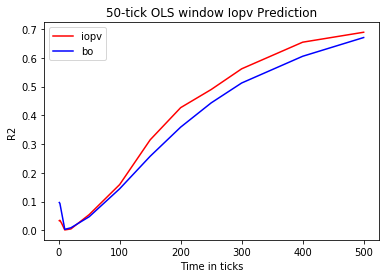

ValueError: Format 'fig' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

In [17]:

os.chdir("C:/Users/Yitong/AppData/Local/auto-option-mm/SpotDetail")
ols_windowlist = [50,100,150,200,300]
lagList = [1,2,5,10,20,50,100,150,200,250,300,400,500]
for ols_window in ols_windowlist:
    gen_iopvSpotTheory(ols_window,mergedDF)    
    botheoR2 = []
    iopvtheoR2 = []
    for lag in lagList:
        (r1,r2) = gen_PredictionGraph(ols_window,mergedDF,lag)
        botheoR2.append(r1)
        iopvtheoR2.append(r2)

    tmpdf = pd.DataFrame(data={'botheoR2':botheoR2,'iopvtheoR2':iopvtheoR2},index=lagList)
    plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
    plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
    plt.xlabel('Time in ticks')
    plt.ylabel('R2')
    plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
    plt.legend()
    plt.show()
    figname = str(ols_window)+"iopv_vs_bo.fig"
    plt.savefig(figname)



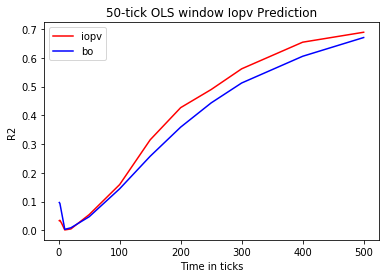

ValueError: Format 'fig' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

In [18]:
plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
plt.xlabel('Time in ticks')
plt.ylabel('R2')
plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
plt.legend()
plt.show()
figname = str(ols_window)+"iopv_vs_bo.fig"
plt.savefig(figname)


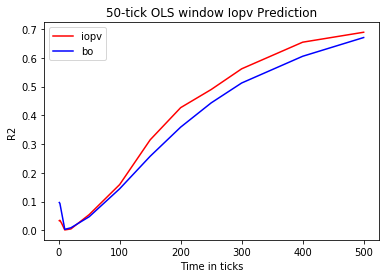

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
plt.xlabel('Time in ticks')
plt.ylabel('R2')
plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
plt.legend()
plt.show()
figname = str(ols_window)+"iopv_vs_bo.png"
plt.savefig(figname)



In [20]:
os.listdir

<function nt.listdir(path=None)>

In [21]:
os.listdir()


['50iopv_vs_bo.png',
 '510050IOPVBO.csv',
 'SpotDetail_20200422_20200417.csv',
 'SpotDetail_20200422_20200421.csv',
 'SpotDetail_20200422_20200422.csv',
 'SpotDetail_20200527_20200417.csv',
 'SpotDetail_20200527_20200421.csv',
 'SpotDetail_20200527_20200422.csv',
 'SpotDetail_20200527_20200423.csv',
 'SpotDetail_20200527_20200424.csv',
 'SpotDetail_20200527_20200427.csv',
 'SpotDetail_20200624_20200417.csv',
 'SpotDetail_20200624_20200421.csv',
 'SpotDetail_20200624_20200422.csv',
 'SpotDetail_20200624_20200423.csv',
 'SpotDetail_20200624_20200424.csv',
 'SpotDetail_20200624_20200427.csv',
 'SpotDetail_20200923_20200417.csv',
 'SpotDetail_20200923_20200421.csv',
 'SpotDetail_20200923_20200422.csv',
 'SpotDetail_20200923_20200423.csv',
 'SpotDetail_20200923_20200424.csv',
 'SpotDetail_20200923_20200427.csv',
 'SpotDetail_20201223_20200423.csv',
 'SpotDetail_20201223_20200424.csv',
 'SpotDetail_20201223_20200427.csv']

In [22]:
plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
plt.xlabel('Time in ticks')
plt.ylabel('R2')
plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
plt.legend()figname = str(ols_window)+"iopv_vs_bo.png"
plt.savefig(figname)
plt.show()




SyntaxError: invalid syntax (<ipython-input-22-3ec0b1541f88>, line 6)

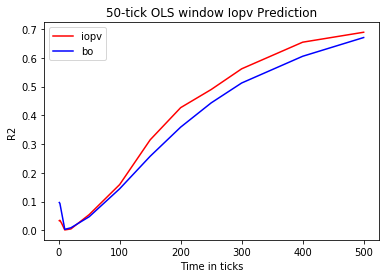

In [23]:
plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
plt.xlabel('Time in ticks')
plt.ylabel('R2')
plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
plt.legend()
figname = str(ols_window)+"iopv_vs_bo.png"
plt.savefig(figname)
plt.show()




.395313

new slope0.597709, new intercept0.399343

new slope0.596406, new intercept0.400667

new slope0.592642, new intercept0.404487

new slope0.589011, new intercept0.408173

new slope0.597456, new intercept0.399602

new slope0.597376, new intercept0.399683

new slope0.603026, new intercept0.393948

new slope0.603710, new intercept0.393254

new slope0.607143, new intercept0.389774

new slope0.612221, new intercept0.384624

new slope0.616131, new intercept0.380659

new slope0.618324, new intercept0.378431

new slope0.614876, new intercept0.381936

new slope0.610688, new intercept0.386191

new slope0.607569, new intercept0.389363

new slope0.611311, new intercept0.385574

new slope0.613563, new intercept0.383296

new slope0.617802, new intercept0.378995

new slope0.627390, new intercept0.369269

new slope0.631152, new intercept0.365454

new slope0.639871, new intercept0.356609

new slope0.645833, new intercept0.350562

new slope0.650931, new intercept0.345385

new slope0.655745, new in

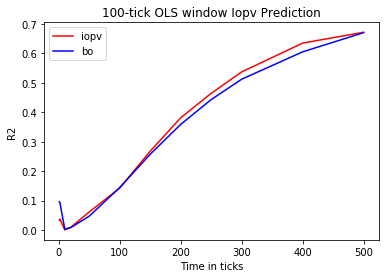

pt0.180932

new slope0.819506, new intercept0.182540

new slope0.821589, new intercept0.180496

new slope0.819910, new intercept0.182155

new slope0.821933, new intercept0.180169

new slope0.820616, new intercept0.181470

new slope0.822712, new intercept0.179410

new slope0.820960, new intercept0.181139

new slope0.823665, new intercept0.178479

new slope0.822375, new intercept0.179753

new slope0.825242, new intercept0.176932

new slope0.823808, new intercept0.178348

new slope0.826447, new intercept0.175753

new slope0.824646, new intercept0.177529

new slope0.827739, new intercept0.174485

new slope0.824891, new intercept0.177293

new slope0.827464, new intercept0.174765

new slope0.824245, new intercept0.177942

new slope0.824447, new intercept0.177749

new slope0.821222, new intercept0.180930

new slope0.822661, new intercept0.179519

new slope0.819760, new intercept0.182383

new slope0.819472, new intercept0.182673

new slope0.814515, new intercept0.187563

new slope0.812730, new

In [24]:
os.chdir("C:/Users/Yitong/AppData/Local/auto-option-mm/SpotDetail")
ols_windowlist = [100,150,200,300]
lagList = [1,2,5,10,20,50,100,150,200,250,300,400,500]
for ols_window in ols_windowlist:
    gen_iopvSpotTheory(ols_window,mergedDF)    
    botheoR2 = []
    iopvtheoR2 = []
    for lag in lagList:
        (r1,r2) = gen_PredictionGraph(ols_window,mergedDF,lag)
        botheoR2.append(r1)
        iopvtheoR2.append(r2)

    tmpdf = pd.DataFrame(data={'botheoR2':botheoR2,'iopvtheoR2':iopvtheoR2},index=lagList)
    plt.plot(tmpdf['iopvtheoR2'], c='red',label='iopv')
    plt.plot(tmpdf['botheoR2'],c='blue',label='bo')
    plt.xlabel('Time in ticks')
    plt.ylabel('R2')
    plt.title(str(ols_window)+ "-tick OLS window Iopv Prediction")
    plt.legend()
    plt.show()
    figname = str(ols_window)+"iopv_vs_bo.png"
    plt.savefig(figname)

